# <h1><center>*Predicting Application Acceptance*</center></h1>

# Goal:

 - Develop a machine learning model that prioritizes recall in identifying high-risk applicants to minimize potential damages caused by accepting them
 ___

# Imports

In [1]:
import pandas as pd
import numpy as np

import wrangle as w
import explore as e
import modeling as m

import seaborn as sns
import matplotlib.pyplot as plt 


from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier


from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings("ignore")

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through CWS Apartment SQL Server.
 - Wrote a SQL query that included 6 different tables and converted to a CSV file
 - Wrote a function in my wrangle.py file that reads CSV file to extract the data
 - It contained 739,442 rows and 25 columns before cleaning
 - Each row represents a resident of the dataset
 - Each column represents a feature of the dataset 
 
 __________

# Prepare

 - Removed columns that were not useful
 - Checked for nulls in the data (column dropped later in pipeline)
 - Checked that column data types were appropriate
 - Renamed columns
 - Filtered data for what we were looking for 
 - Removed Outliers
 - Encoded variables that would promote useability for models
 - Created dummy variables for categorical variables
 - Added dummy variables to dataset
 - Split data into train, validate and test (approx. 56/24/20)
 
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| --------------- | ------------------ |
|      bad_resident    | 1 for resident that caused loss to company, 0 for otherwise |

| Feature  | Definition |
| ------------- | ------------- |
| id | Tenant Identification Number |
| total_charges | Total charges resident has incurred living at apartment   |
| amount_paid | Amount tenant has paid towards total charges |
| open |  0 is transaction total charge is closed -1 is transaction total charge open|
| charge_code | Code of a charge  |
| description | Description of a charge with date|
| prop_id | Related to property name and location  |
| charge_name | Name of a charge  |
| sStatus | Status of a tenant (current or past) |
| rent | Rent per month |
| term | Lease contract in months |  
| monthly_inc | Monthly income of a tenant |
| GuarantorRequired | If a tenant requires a guarrantor |
| total_inc | Yearly income of a tenant |
| Recommendation | Acceptance status of applicant |
| age | Age of a tenant |
| risk_score | Predetermined score of how risky an applicant is at the time of applying |
| reason | Reason that drove decision to recommedation |

_____

# A brief look at the data

In [2]:
# acquiring and cleaning the data
df = w.get_cws_data()

# splitting data into subsets of train, validate, test with X and y splits
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = w.train_vailidate_test_split(df, 'bad_resident', 'bad_resident')

In [3]:
#displaying all columns and getting first 5 rows
train.head()

,id,total_charges,amount_paid,open,charge_code,description,prop_id,charge_name,sStatus,rent,term,monthly_income,GuarantorRequired,total_income,Recommendation,age,risk_score,reason,bad_resident
2707,63851,2.00,2.00,0,190,Pest control (02/2023),126,Pest control,Current,1639,12,3900,False,0,A-Criminal History Meets Requirements,27,0,Meets All Property Requirements,0
4983,73919,1650.00,1650.00,0,21,Deposit (Amounts subject to screening results),103,Deposit received,Current,1719,12,6600,False,75684,Accept with Conditions (Extra Deposit),31,745,NaN,0
4959,73653,4.00,4.00,0,180,Next Month's Administration Processing Fee,84,Administration processing fee,Current,1661,9,8176,False,221364,Accept with Conditions (Extra Deposit),37,687,Limited period of Employment History,0
4492,70961,0.33,0.33,0,190,Pest Control for 5 days,80,Pest control,Current,1579,14,5000,False,101976,Accept,29,782,Meets All Property Requirements,0
995,33019,1.17,1.17,0,190,Pest Control for 7 days,139,Pest control,Current,1779,13,7500,False,90000,Accept,31,724,Meets All Property Requirements,0


# A summary of the data

In [4]:
# a look at our column names, data types, and null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799 entries, 2707 to 4980
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2799 non-null   int64  
 1   total_charges      2799 non-null   float64
 2   amount_paid        2799 non-null   float64
 3   open               2799 non-null   int64  
 4   charge_code        2799 non-null   int64  
 5   description        2799 non-null   object 
 6   prop_id            2799 non-null   int64  
 7   charge_name        2799 non-null   object 
 8   sStatus            2799 non-null   object 
 9   rent               2799 non-null   int64  
 10  term               2799 non-null   int64  
 11  monthly_income     2799 non-null   int64  
 12  GuarantorRequired  2799 non-null   bool   
 13  total_income       2799 non-null   int64  
 14  Recommendation     2799 non-null   object 
 15  age                2799 non-null   int64  
 16  risk_score         27

# Explore

In [5]:
train.prop_id = train.prop_id.apply(e.states)

### *1. What is the average risk score?*

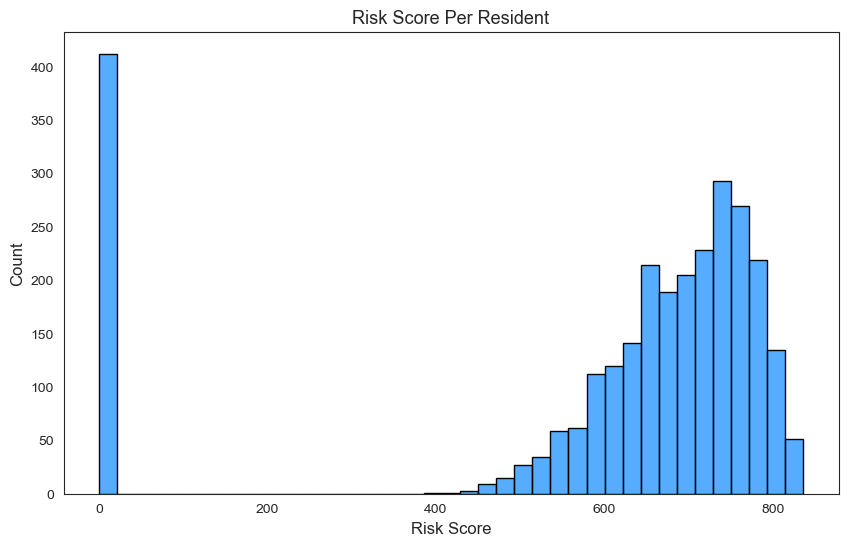

In [6]:
e.hist_data_inc(train, 'risk_score', color = 'dodgerblue')

**Takeaways**

- The average risk score is 591.29
- From this chart there are about 400 residents with 0 risk, but because the information doesn't seem to have been inputted. 

____

### *2. Is risk score an indicator of a loss?*

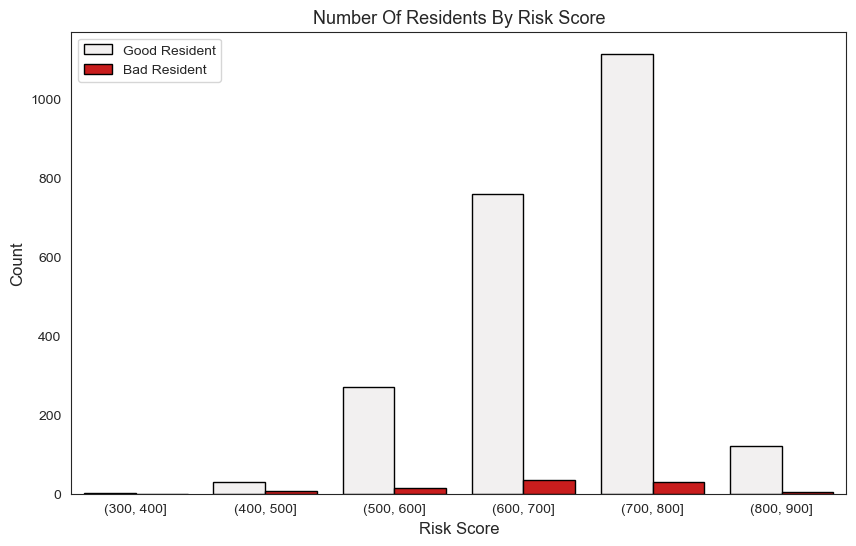

In [7]:
e.countplot_a(train, 'risk_score', color = '#E50000', bad = True)

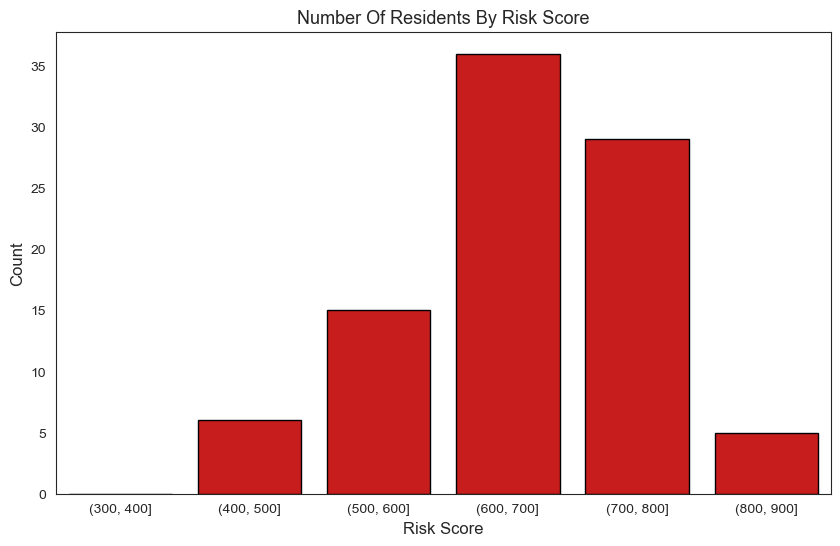

In [8]:
e.countplot_a(train, 'risk_score', color = '#E50000')

**Takeaways**

- Higher risk score is not associated with likley loss but within 600-800 range does have the highest percent


**Ran a $Chi^2$ test to evaluate if there is dependecy between risk score and what we consider a bad resident** <br>

    
$H_0$: Risk score is not dependent on whether a resident will be considered as a bad resident for lost money<br>
$H_a$: Risk score is dependent on whether a resident will be considered as a bad resident for lost money

 - Confidence interval of 95%
 - Alpha is .05

In [9]:
e.chi_test_a(train, 'risk_score')

We reject the null hypothesis.

Chi2 = 8.905
P-value = 0.031


**Takeaways**

-  $Chi^2$ test using bins found risk score is statistically siginificant to bad residents. A good indicator of loss.

____

### *3. Is monthly/yearly income an indicator of loss?*

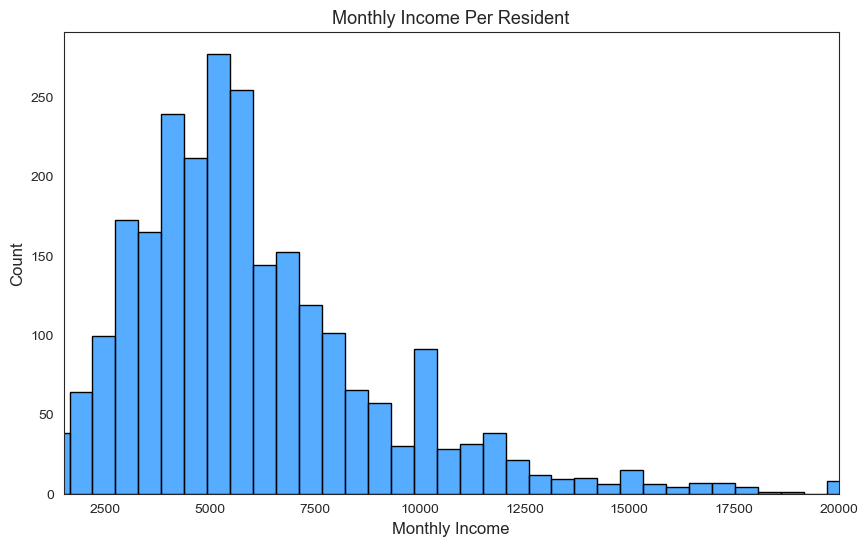

In [10]:
e.hist_data_inc(train, 'monthly_income', xlim =[1500, 20000], color = 'dodgerblue')

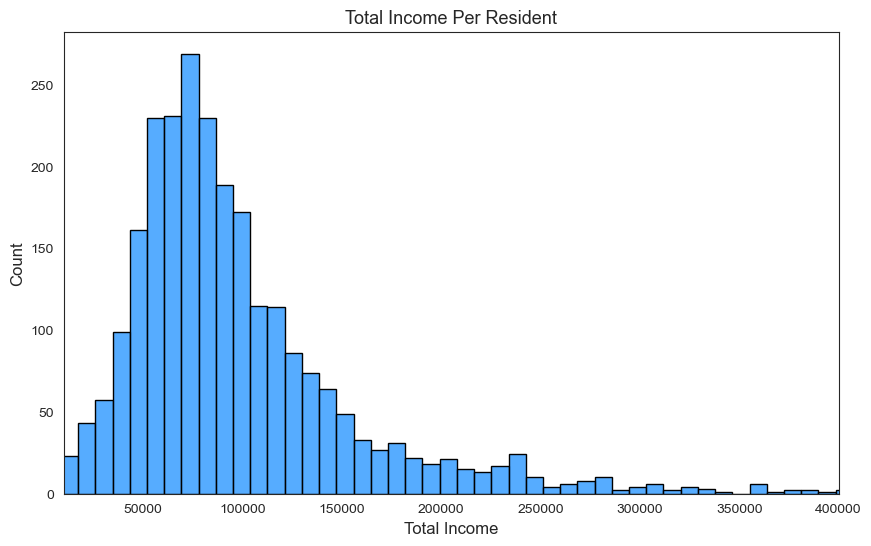

In [11]:
e.hist_data_inc(train, 'total_income', xlim =[10000, 400000], color = 'dodgerblue')

**Takeaways**

- Income becomes relevelent when placed into quartiles, the highet quartile does highest % of damage 

**Ran a $Chi^2$ test to evaluate if there is dependecy between risk score and what we consider a bad resident** <br>

    
$H_0$: Monthly Income is not dependent on whether a resident will be considered as a bad resident for lost money<br>
$H_a$: Monthly Income is dependent on whether a resident will be considered as a bad resident for lost money

 - Confidence interval of 95%
 - Alpha is .05

In [12]:
e.chi_test_a(train, 'monthly_income')

We fail to reject the null hypothesis.

Chi2 = 0.946
P-value = 0.814


**Takeaways**


- Not the best indicator, as monthly income was found to not be statistically significant. Meaning monthly income and bad resident do not have a dependency.

____

### *4. Is requirement of a guarantor  a good driver?*

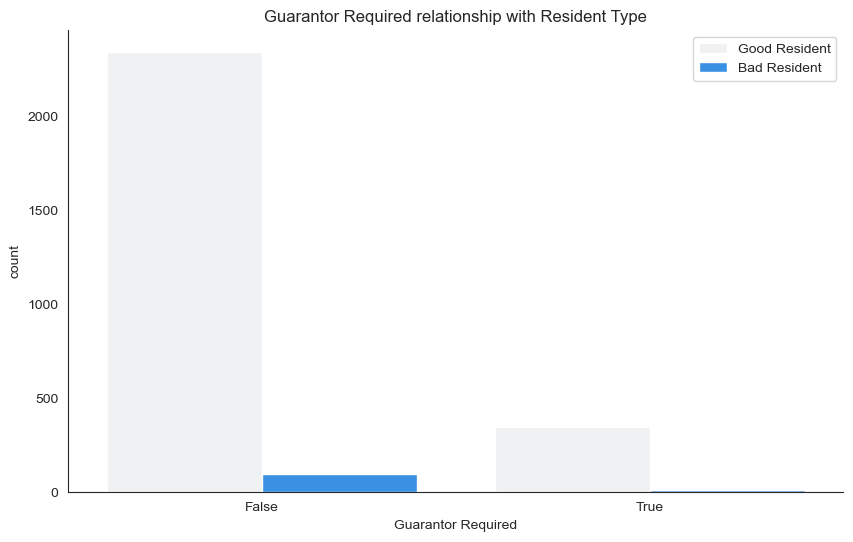

In [13]:
e.vis_countplot(train, col = 'GuarantorRequired')

**Takeaways**

- From graph, we can see that Guarantor required have very minimal affect on resident being bad resident


In [14]:
e.chi_test_g(train, col = 'GuarantorRequired')

Null Hypothesis: GuarantorRequired and bad_resident are independent

Alternative Hypothesis: GuarantorRequired and bad_resident are dependent

chi^2 = 0.15460781387865227
p     = 0.6941702916474859

We fail to reject null hypothesis
There appears to be no significant relationship between GuarantorRequired and bad_resident.


**Takeaways**

- From result of chi square test, we can say that Guarantor have no significant relations with bad resident.

____

### *5. Is there a relationship between rent and damages?*

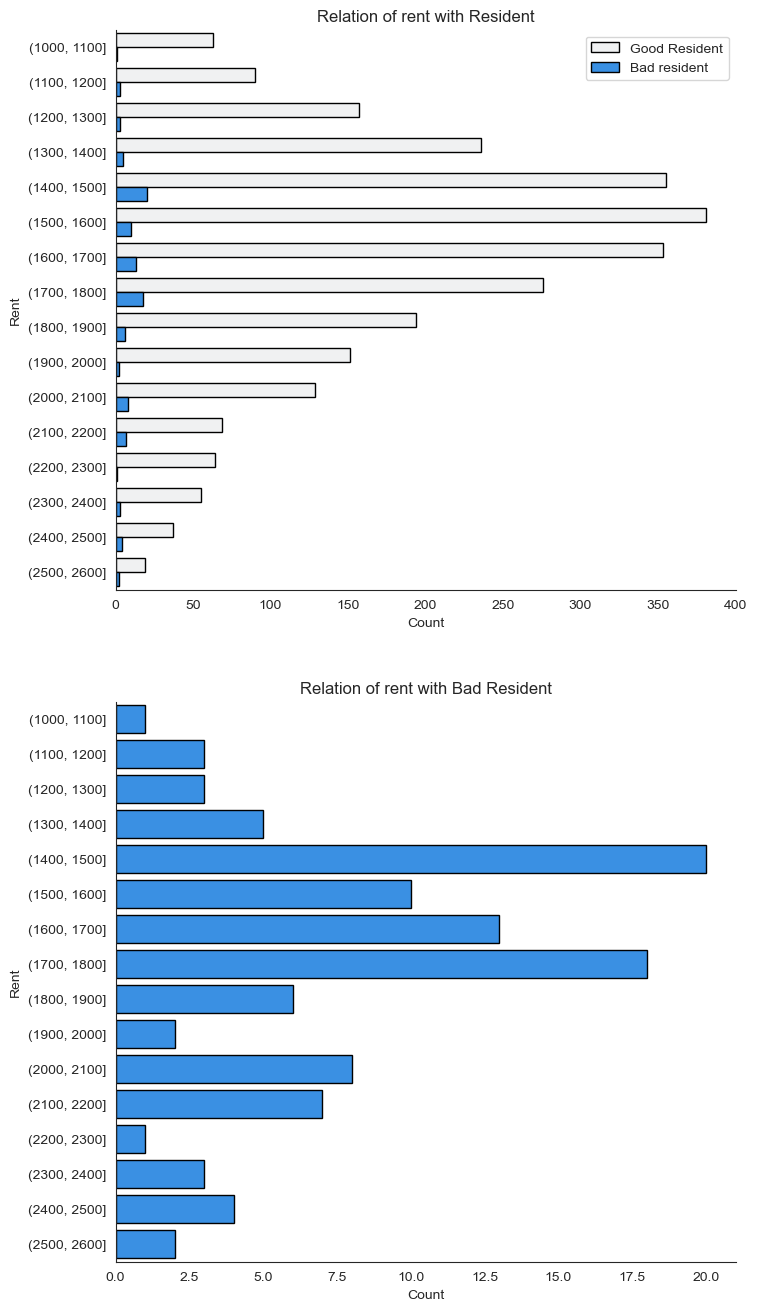

In [15]:
e.viz_rent(train, 'rent')

**Takeaways**

- From graph, we can say that residents with rent 1400-1500 are considered as the bad resident.

____

### *6. Are certain age groups more likely to cause damage?*

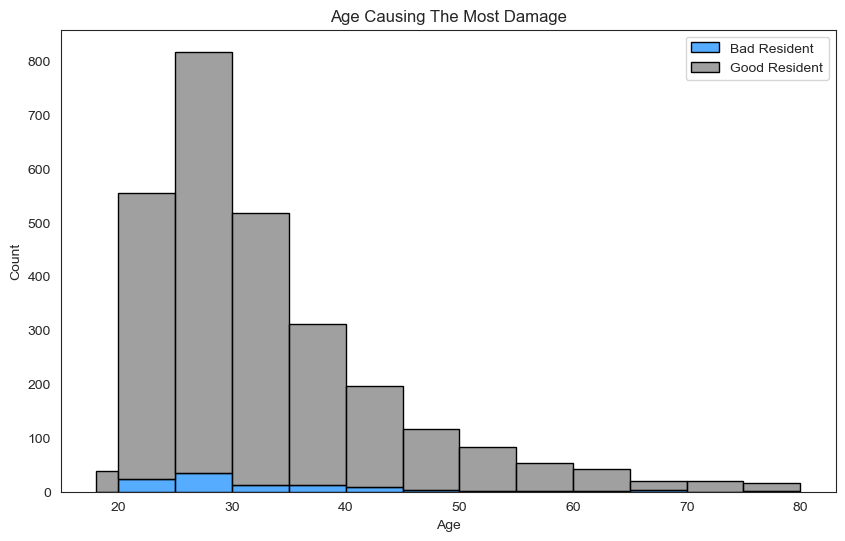

In [16]:
e.histplot_n(train, 'age')

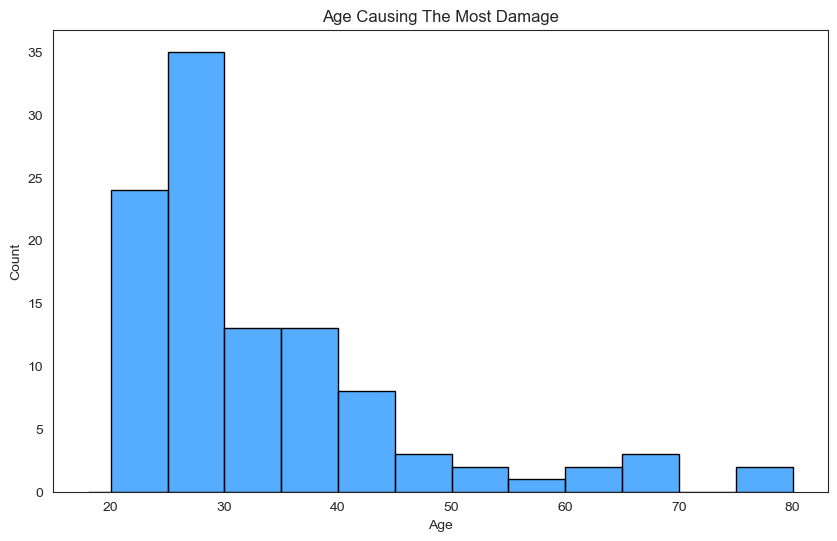

In [17]:
e.histplot_n(train, 'age', bad = True)

**Takeaways**

- Looking at our histograms, it seems the younger you are the more damage is caused by residents

**Ran a $Chi^2$ test to evaluate if there is dependecy between age and what we consider a bad resident** <br>

    
$H_0$: Age is not dependent on whether a resident will be considered as a bad resident for damages caused<br>
$H_a$: Age is dependent on whether a resident will be considered as a bad resident for damages caused

 - Confidence interval of 95%
 - Alpha is .05

In [18]:
e.chi_test(train, col = 'age')

We reject the null hypothesis.

Chi2 = 104.354
P-value = 0.004


**Takeaways**

- We reject the null hypothesis. Meaning damage is dependent on the age of the resident.
- Younger residents are more likely to cause damage than older residents

____

### *7. Are short term renters more likely to cause damage?*

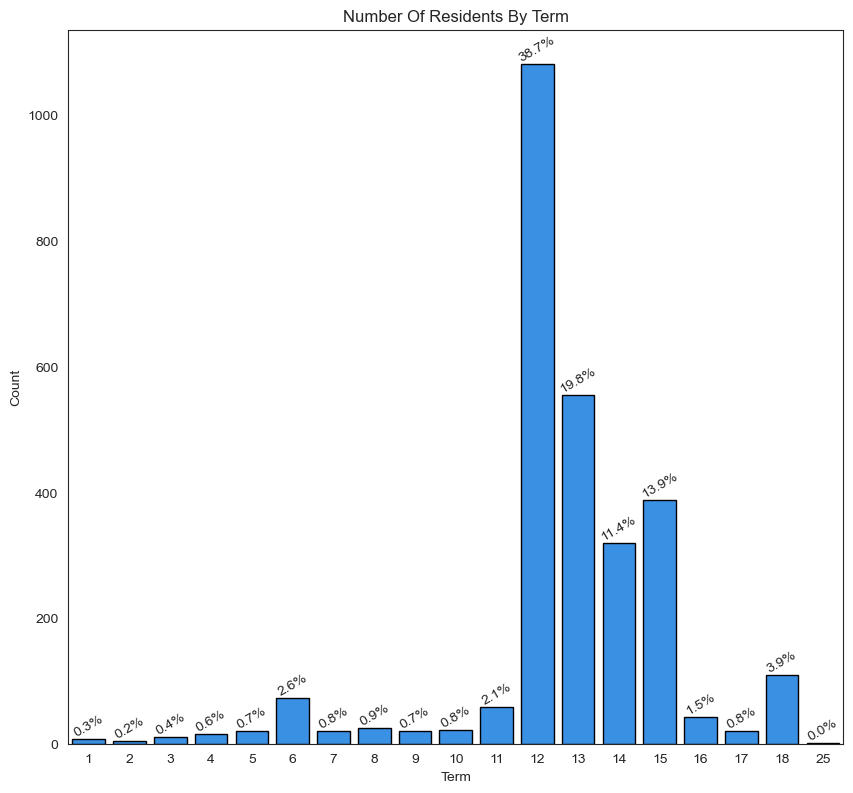

In [19]:
e.countplot(train, 'term', 'dodgerblue')

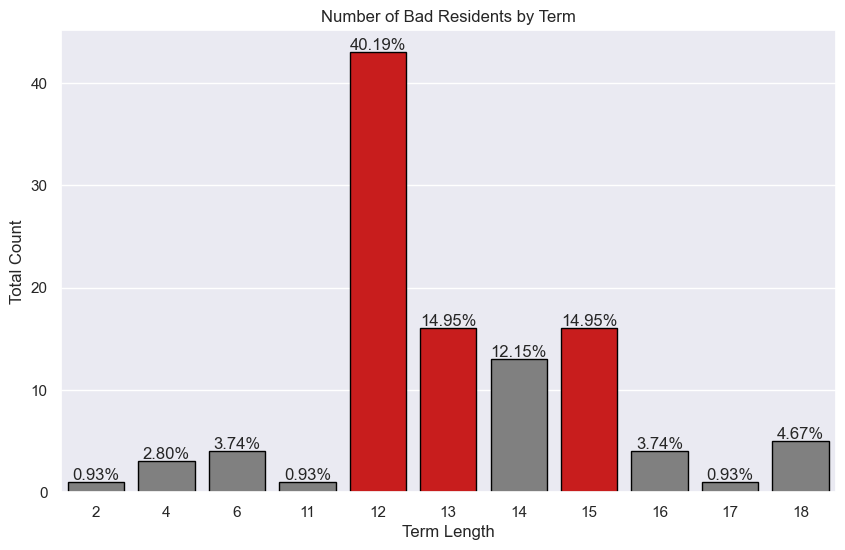

In [20]:
e.countplot_n(train, 'term', bad = True)

**Takeaways**

- Residents with a longer term contract are causing more damage, which makes sense because they are at the apartment for longer time.

**Ran a $Chi^2$ to evaluate if damage (short term renters more likely to or not) is more prevelant among short term renters** <br>

$H_0$: Term lease is not dependent on damage<br>
$H_a$: Term lease is dependent on damage

 - Confidence interval of 95%
 - Alpha is .05

In [21]:
e.chi_test(train, col = 'term')

We fail to reject the null hypothesis.

Chi2 = 24.848
P-value = 0.129


**Takeaways**

- From our stats test We fail to reject the null hypothesis. Meaning term lease and damage have not dependency. 
- From our countplots we see damage is mostly caused within the 12 to 15 month term lease compared to the other term lease. So it seem significant enough to apply to our models to see what we get back

____

### *8. What is the most common damage code?*

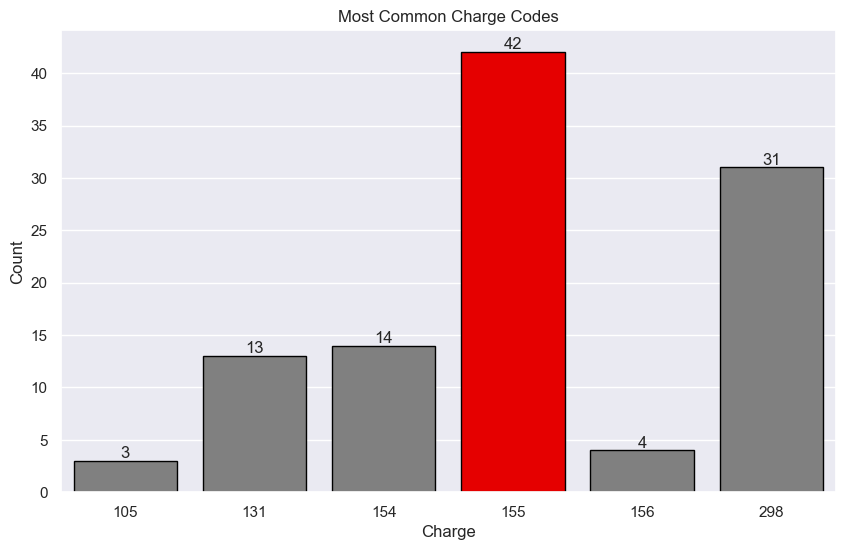

In [22]:
e.get_common(train)

**Takeaways**

- Charge code 155 is a charge code for damage to various things within the property.

____

### *9. Do certain property have more damages?*

<Figure size 1000x600 with 0 Axes>

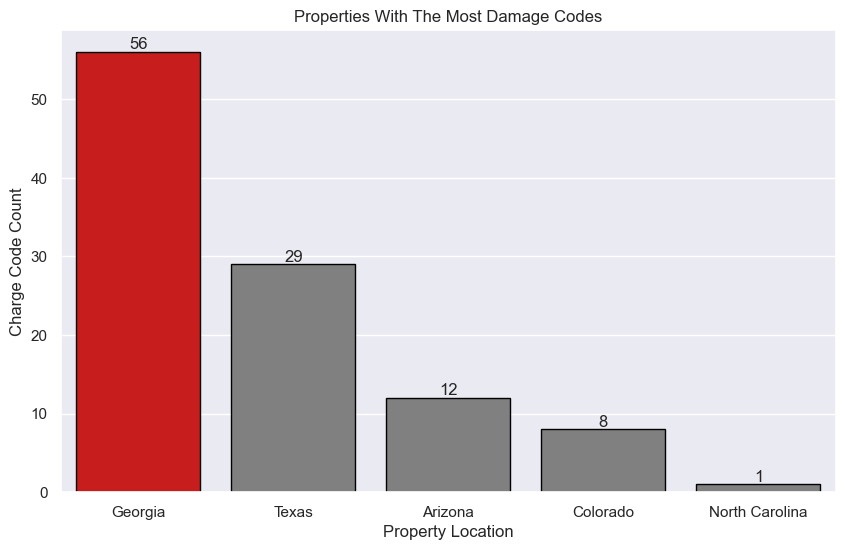

In [23]:
e.plot_bad_properties(train)

**Takeaways**

- Georgia seems to have the most properties with damage charges

____

# Exploration Summary

**- All features will be used in modeling except for Guarantor required feature (statisically significant and not i.e. Monthly Income/Age)**<br>
**- Atlanta area properties had the most amount of loss compared to all properties**<br>
**- Longer term residents within 12-15 months caused the most loss**<br>
**- Residents between 600 - 800 had the most charge codes**


 ------

# Modeling 

- Goal is to minimize Recall, so this will be my evaluation metric
- Ran over 100 models with the following algorithmns: Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbors, Ensemble and XGBoost 
- Before modeling scaled data and split
- We evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

In [24]:
# spliting our dat into subsets to model 
train, validate, test, y_train, y_val, y_test, train_scaled, val_scaled, test_scaled = w.model_prep(df)

In [25]:
# Logistic Regression Model
log_model = m.logistic_regression_model(train_scaled, y_train, val_scaled, y_val)

In [26]:
# KNN Model
knn_model= m.get_knn(train, val_scaled, y_val)

In [27]:
# Random Forest NC Model
rf_nc_model = m.randomforestNC(train_scaled, y_train, val_scaled, y_val)

In [28]:
# Random Forest SMOTE Model
rf_smote_model = m.randomforestSMOTE(train_scaled, y_train, val_scaled, y_val)

In [29]:
# Random Forest ADASYN Model
rf_adasyn_model = m.randomforestADASYN(train_scaled, y_train, val_scaled, y_val)

In [30]:
# XGBoost SMOTE Model
xg_smote_model = m.xgboostSMOTE(train_scaled, y_train, val_scaled, y_val)

[0]	validation_0-logloss:0.66896	validation_0-roc_auc_score:0.79628	validation_1-logloss:0.68046	validation_1-roc_auc_score:0.68749


In [31]:
# XGBoost SMOTE NC Model
xg_smote_nc_model = m.xgboostSMOTENC(train_scaled, y_train, val_scaled, y_val)

[0]	validation_0-logloss:0.67577	validation_0-roc_auc_score:0.80753	validation_1-logloss:0.68570	validation_1-roc_auc_score:0.64345


In [32]:
# XGBoost ADASYN Model
xg_adasyn_model = m.xgboostADASYN(train_scaled, y_train, val_scaled, y_val)

[0]	validation_0-logloss:0.66816	validation_0-roc_auc_score:0.79963	validation_1-logloss:0.67923	validation_1-roc_auc_score:0.67568
[1]	validation_0-logloss:0.65916	validation_0-roc_auc_score:0.81088	validation_1-logloss:0.67932	validation_1-roc_auc_score:0.67580


In [33]:
# Ensemble Model
ensemble_model = m.ensemble(train_scaled, y_train, val_scaled, y_val)

In [34]:
df= m.comparing_models(train, train_scaled, y_train, val_scaled, y_val)

[0]	validation_0-logloss:0.66896	validation_0-roc_auc_score:0.79628	validation_1-logloss:0.68046	validation_1-roc_auc_score:0.68749
[1]	validation_0-logloss:0.66250	validation_0-roc_auc_score:0.80522	validation_1-logloss:0.68212	validation_1-roc_auc_score:0.69935
[0]	validation_0-logloss:0.67577	validation_0-roc_auc_score:0.80753	validation_1-logloss:0.68570	validation_1-roc_auc_score:0.64345
[0]	validation_0-logloss:0.66816	validation_0-roc_auc_score:0.79963	validation_1-logloss:0.67923	validation_1-roc_auc_score:0.67568


In [35]:
df

,Model,Train Recall,Validation Recall
0,xg_smote_model,0.98,0.830000
1,xg_adasyn_model,0.95,0.720000
2,xg_smote_nc_model,0.87,0.650000
3,rf_adasyn_model,0.73,0.630000
4,ensemble_model,0.66,0.630000
5,rf_nc_model,0.71,0.610000
6,rf_smote_model,0.74,0.610000
7,knn_model,0.94,0.130435
8,log_model,0.01,0.000000


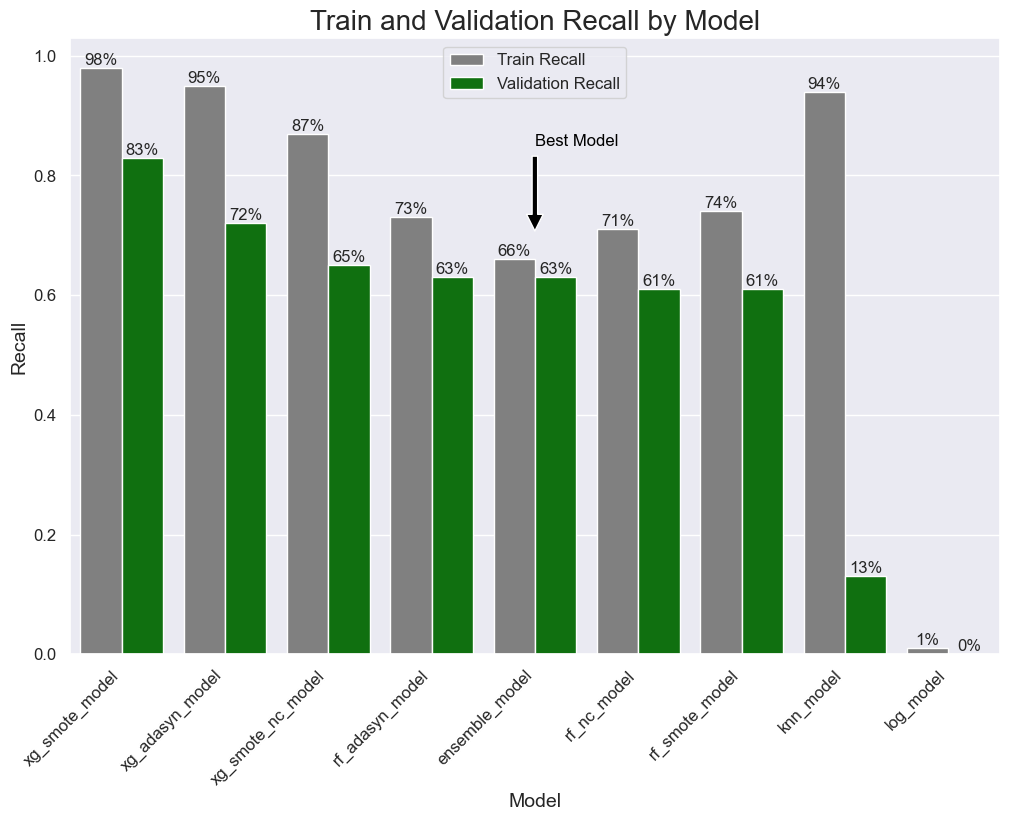

In [36]:
m.models(df)

### **The best performing model is the ensemble, so we tested the model with the test data**

In [37]:
# this is the best model and ran the test data on it
m.ensemble(train_scaled, y_train, test_scaled, y_test)

,train_ensemble,validate_ensemble
0,0.81,0.81
1,0.66,0.55


------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>    
</header>    
<dt>
    

<br>        
Best Model's performance:

</dt>

<header>
    <h2>Recommendations:</h2>        
</header>      
<dl>
    

 

<header>
    <h2> Next Steps:</h2>       
</header> 
</dl>
    


</div>